In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DL_assignment/image-20210112T150225Z-001.zip
!unzip /content/drive/MyDrive/DL_assignment/label-20210112T150240Z-001.zip

### Install the necessary packages

In [ ]:
# !pip install tensorflow==2.2.0

### Import Packages

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import InceptionResNetV2, VGG16, ResNet50V2, MobileNetV2, InceptionV3
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

from tensorflow.keras import regularizers

### Function to display images in Jupyter Notebooks and Google Colab

In [ ]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Define our `Config` class

In [ ]:
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH_IMAGE = "/content/image"
BASE_PATH_LABEL = "/content/label"


# define the path to the base output directory
BASE_OUTPUT = "/content/output"

# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

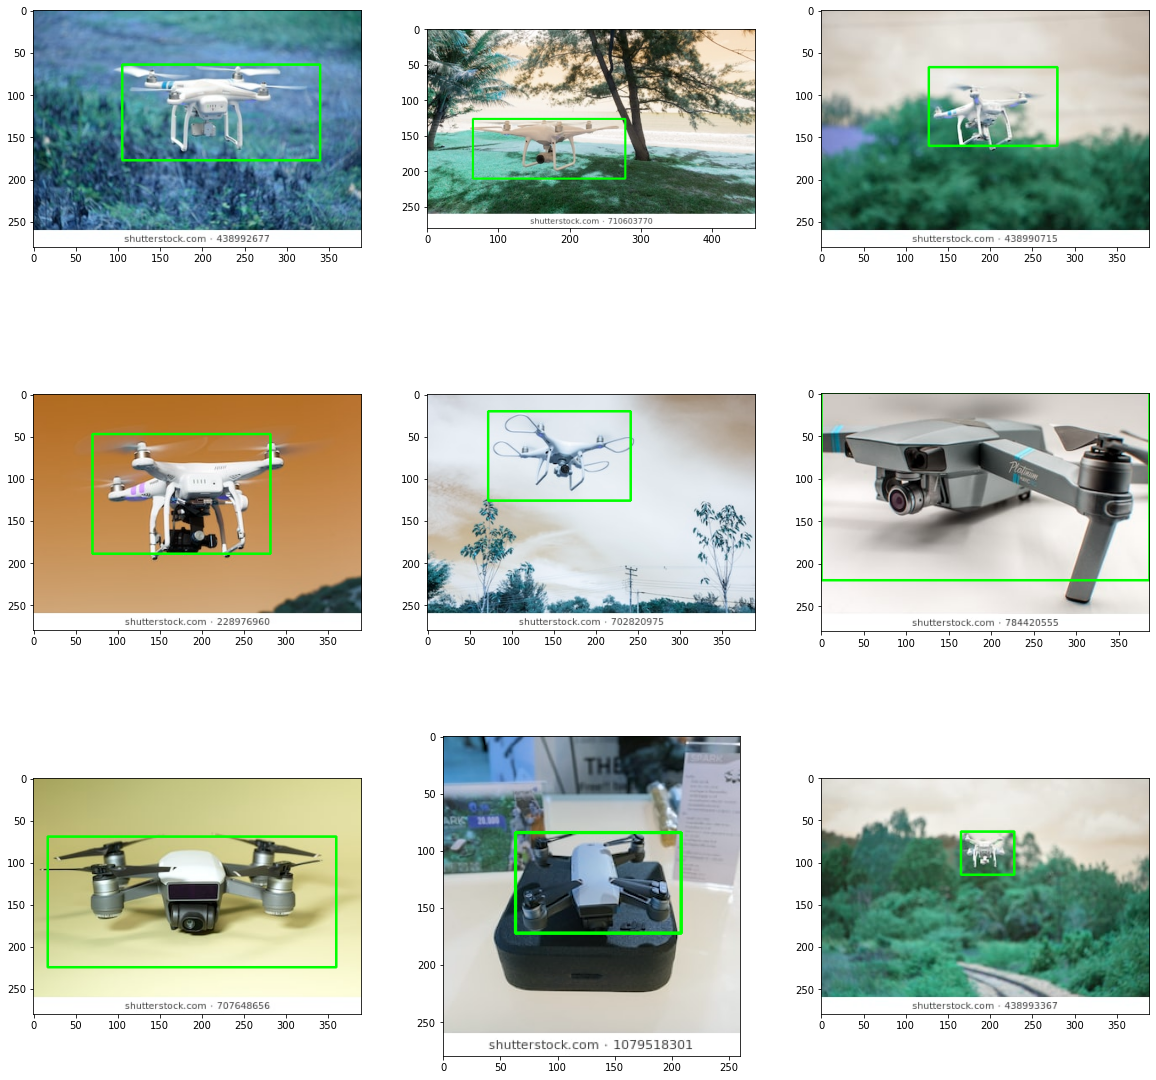

In [ ]:
from IPython.core.pylabtools import figsize
ax, fig = plt.subplots(5, 5, figsize = (20,20))
i = 0
# plot first few images
for name in os.listdir(BASE_PATH_LABEL):

    # break the row into the filename and bounding box coordinates
    filename = name.split(".")[0]
    row = open(BASE_PATH_LABEL + '/' + name).read().split()
    (label, X, Y, W, H) = row
    X, Y, W, H = float(X), float(Y), float(W), float(H)

    startX = int(X)
    startY = int(Y)
    endX = int(X + W)
    endY = int(Y + H)
    imagePath = os.path.sep.join([BASE_PATH_IMAGE, filename + '.jpg'])
    #image = load_img(imagePath)
    image = cv2.imread(imagePath)
    #image = img_to_array(image)
    cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
    # plot raw pixel data
    plt.subplot(330 + 1 + i)
    plt.imshow(image)
    # show the figure upto 9 images
    i += 1
    if i > 8:
        break
       



In [ ]:
import tensorflow as tf
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes

In [ ]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.79547>

In [ ]:
path = '/content/label'

data = []
targets = []
filenames = []

aug_data = []
aug_target = []

# loop over the label folder
for name in os.listdir(path):
	# break the row into the filename and bounding box coordinates
    filename = name.split(".")[0]
    row = open(path + '/' + name).read().split()
    (label, X, Y, W, H) = row

    X, Y, W, H = float(X), float(Y), float(W), float(H)

    startX = X
    startY = Y
    endX = X + W
    endY = Y + H

	# derive the path to the input image, load the image (in OpenCV
	# format), and grab its dimensions
    imagePath = os.path.sep.join([BASE_PATH_IMAGE, filename + '.jpg'])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]

    

	# scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
    startX = max(float(startX) / w, 0.0)
    startY = max(float(startY) / h, 0.0)
    endX = max(float(endX) / w, 0.0)
    endY = max(float(endY) / h, 0.0)

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224)) # Image size for inceptionresnetv2 model
    image = img_to_array(image)
    # if tf.random.uniform(()) > 0.5:
    #     aug_image = np.fliplr(image)

    #     aug_startX = w - X - W
    #     aug_startY = Y
    #     aug_endX = w - X
    #     aug_endY = Y + H

    #     aug_startX = float(aug_startX) / w
    #     aug_startY = float(aug_startY) / h
    #     aug_endX = float(aug_endX) / w
    #     aug_endY = float(aug_endY) / h
    #     data.append(aug_image)
    #     targets.append((aug_startX, aug_startY, aug_endX, endY))

    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

In [ ]:
len(targets)

314

In [ ]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.15, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [ ]:
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off InceptionResNetV2, VGG16, MobileNetV2, InceptionV3
inceptionv2 = VGG16(weights="imagenet", include_top=False,
 	input_tensor=Input(shape=(224, 224, 3)))


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# freeze all VGG layers so they will *not* be updated during the
# training process
inceptionv2.trainable = False
# flatten the max-pooling output of VGG
flatten = inceptionv2.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(150, kernel_initializer='he_uniform', activation="LeakyReLU")(flatten)
#bboxHead = Dense(150,kernel_initializer='he_uniform', activation="LeakyReLU")(bboxHead)
bboxHead = Dropout(0.2)(bboxHead)
bboxHead = Dense(100, kernel_initializer='he_uniform', activation="LeakyReLU")(bboxHead)
#bboxHead = Dropout(0.2)(bboxHead)
#bboxHead = Dense(60, activation="relu")(bboxHead)
bboxHead = Dense(50, kernel_initializer='he_uniform', activation="LeakyReLU")(bboxHead)
#bboxHead = Dropout(0.15)(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=inceptionv2.input, outputs=bboxHead)

In [ ]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 30
BATCH_SIZE = 32

In [ ]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="mean_squared_logarithmic_error", optimizer=opt, metrics = ['accuracy'])
#print(model.summary())

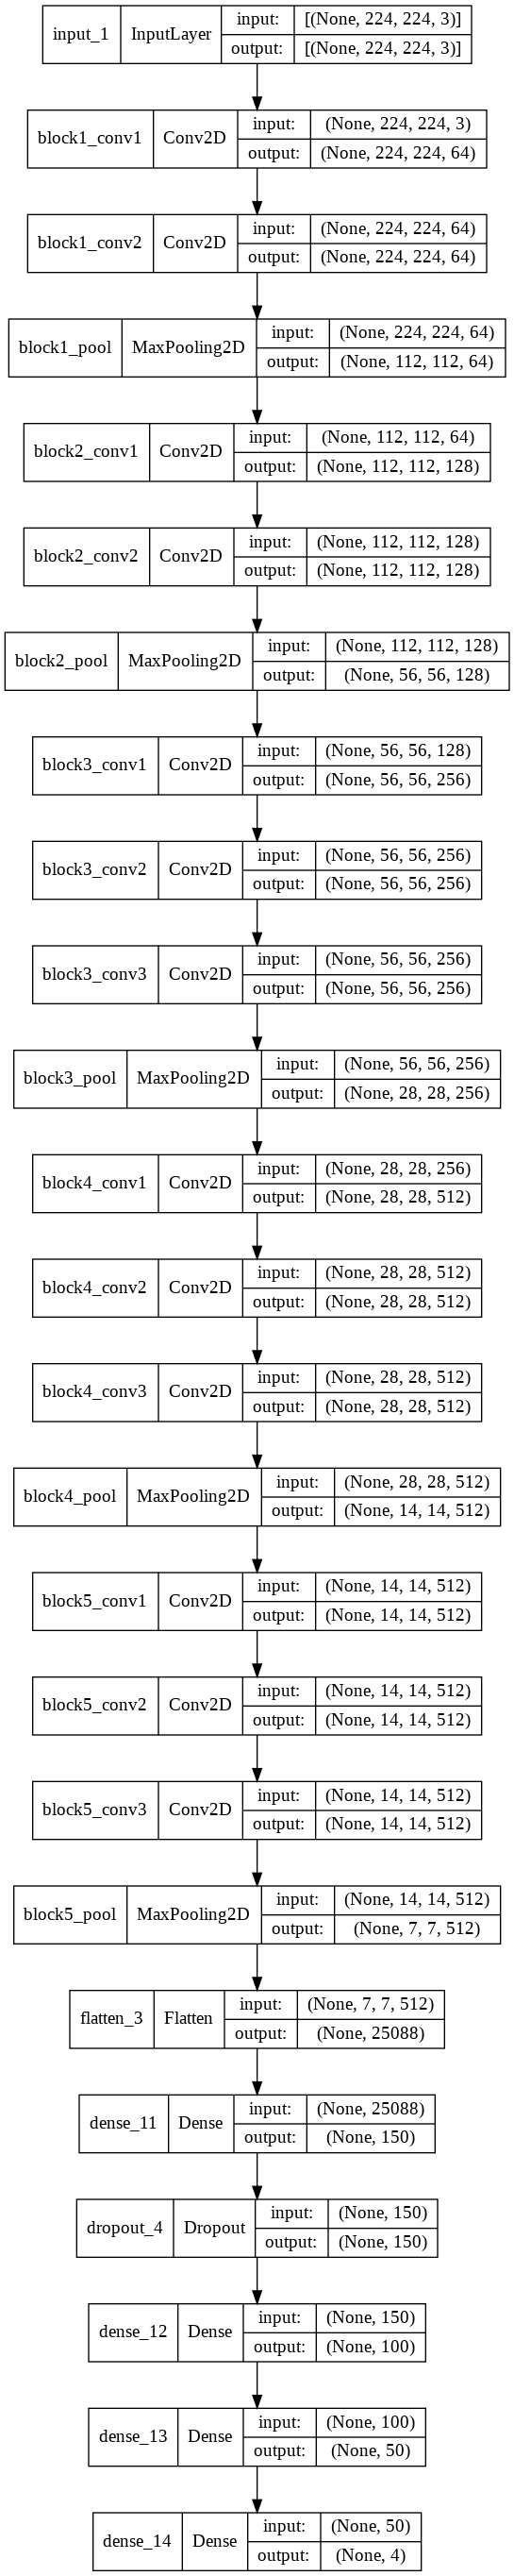

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

[INFO] training bounding box regressor...
Epoch 1/30
9/9 [==============================] - 3s 139ms/step - loss: 0.0257 - accuracy: 0.5150 - val_loss: 0.0139 - val_accuracy: 0.6042
Epoch 2/30
9/9 [==============================] - 1s 92ms/step - loss: 0.0149 - accuracy: 0.5376 - val_loss: 0.0094 - val_accuracy: 0.7708
Epoch 3/30
9/9 [==============================] - 1s 91ms/step - loss: 0.0076 - accuracy: 0.6692 - val_loss: 0.0057 - val_accuracy: 0.8333
Epoch 4/30
9/9 [==============================] - 1s 83ms/step - loss: 0.0066 - accuracy: 0.6955 - val_loss: 0.0049 - val_accuracy: 0.8542
Epoch 5/30
9/9 [==============================] - 1s 81ms/step - loss: 0.0048 - accuracy: 0.7256 - val_loss: 0.0043 - val_accuracy: 0.8125
Epoch 6/30
9/9 [==============================] - 1s 81ms/step - loss: 0.0035 - accuracy: 0.7857 - val_loss: 0.0039 - val_accuracy: 0.8542
Epoch 7/30
9/9 [==============================] - 1s 80ms/step - loss: 0.0029 - accuracy: 0.8045 - val_loss: 0.0039 - val_a

[INFO] saving object detector model...


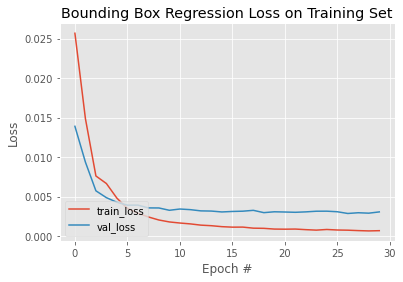

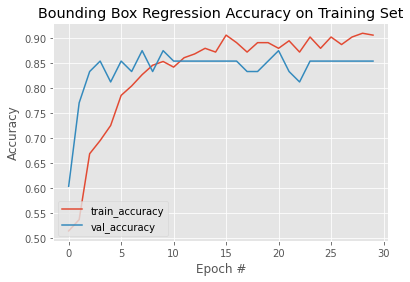

In [ ]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
plt.title("Bounding Box Regression Accuracy on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

### Implementing our bounding box predictor with Keras and TensorFlow

In [ ]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to input image/text file of image filenames")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "input": "output/test_images.txt"
}

In [ ]:
# determine the input file type, but assume that we're working with
# single input image
filetype = mimetypes.guess_type(args["input"])[0]
imagePaths = [args["input"]]

# if the file type is a text file, then we need to process *multiple*
# images
if "text/plain" == filetype:
	# load the filenames in our testing file and initialize our list
	# of image paths
	filenames = open(args["input"]).read().strip().split("\n")
	imagePaths = []
	labels = []

	# loop over the filenames
	for f in filenames:
		# construct the full path to the image filename and then
		# update our image paths list
		p = os.path.sep.join([BASE_PATH_IMAGE, f])
		l = os.path.sep.join([BASE_PATH_LABEL, f])
		imagePaths.append(p+'.jpg')
		labels.append(l +'.txt')

In [ ]:
len(labels)

48

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

[INFO] loading object detector...


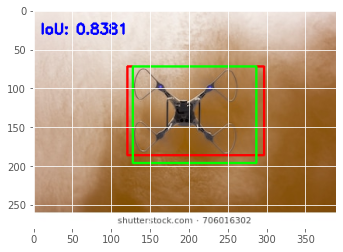

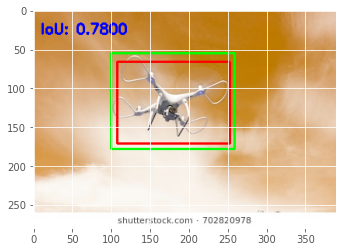

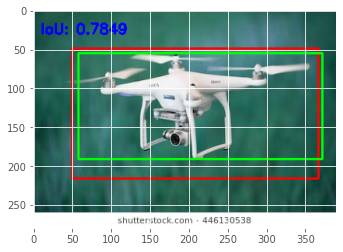

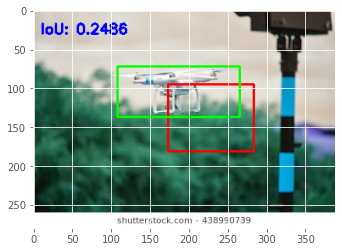

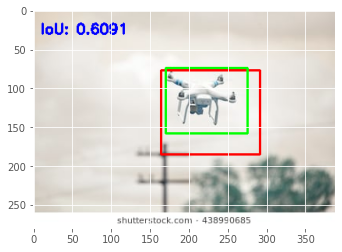

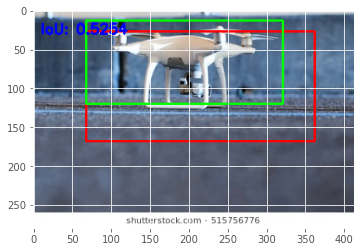

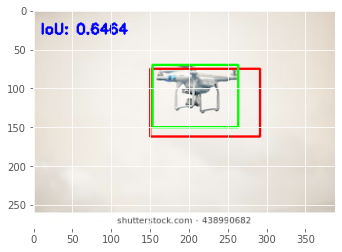

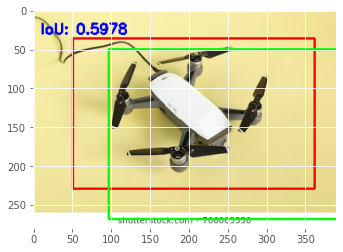

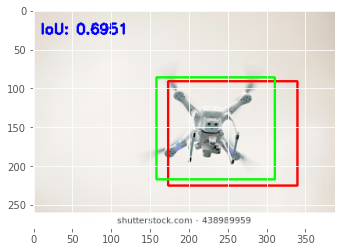

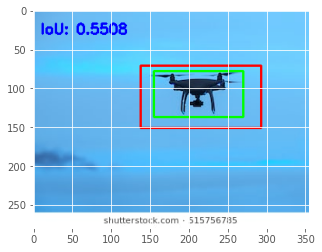

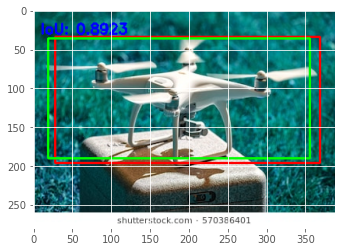

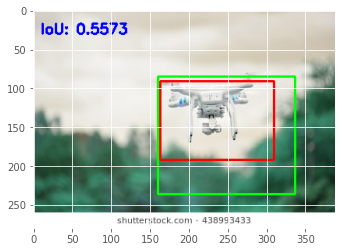

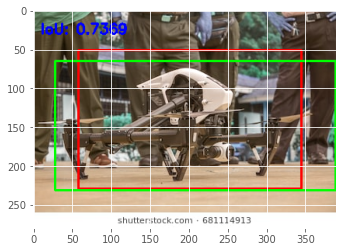

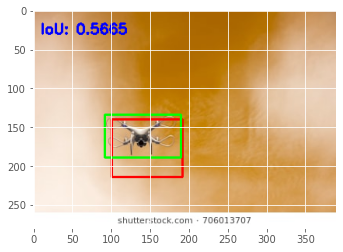

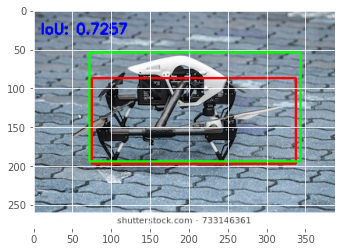

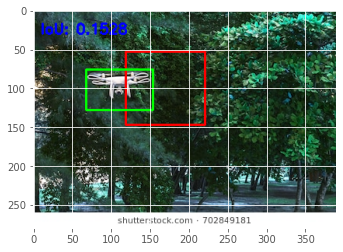

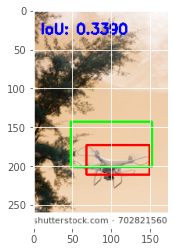

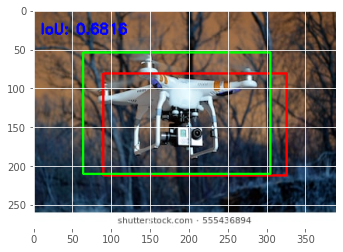

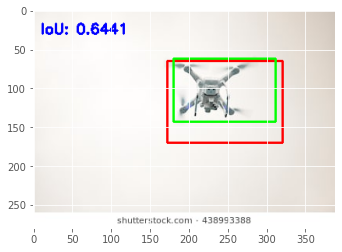

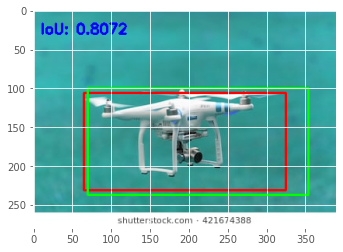

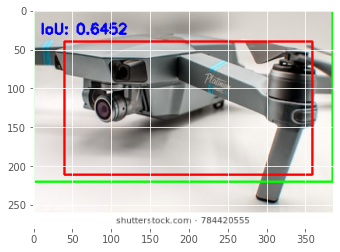

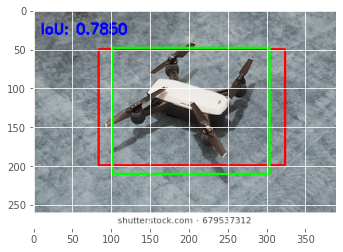

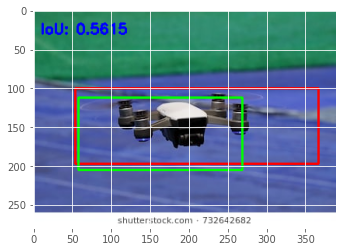

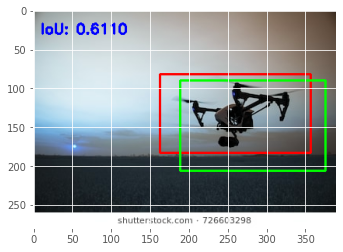

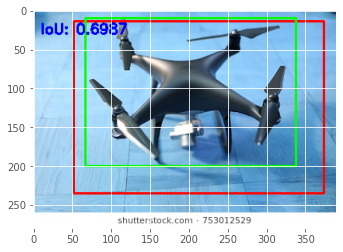

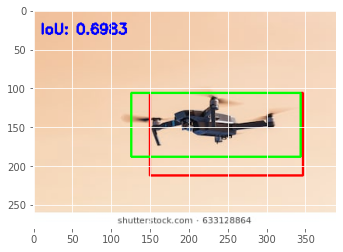

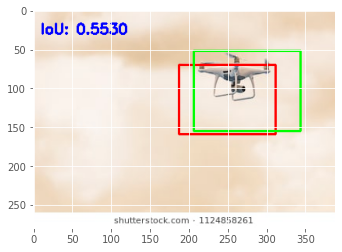

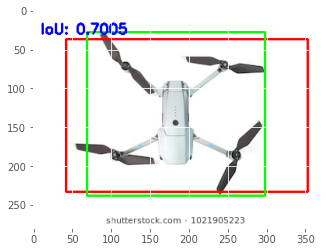

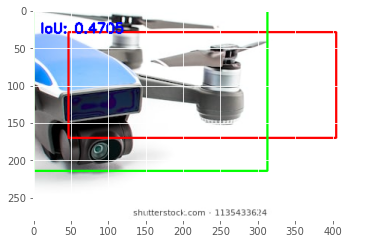

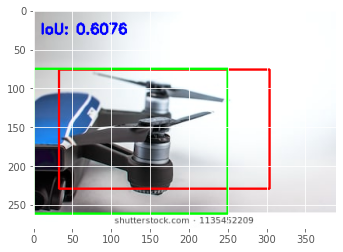

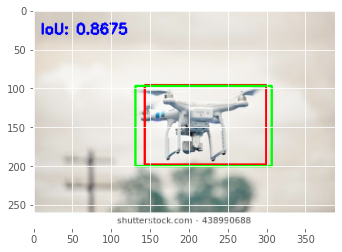

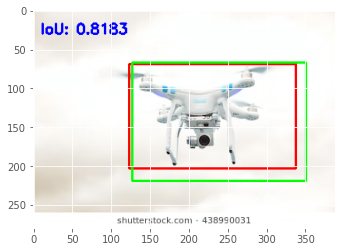

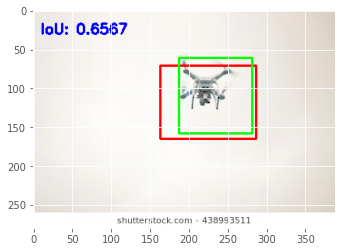

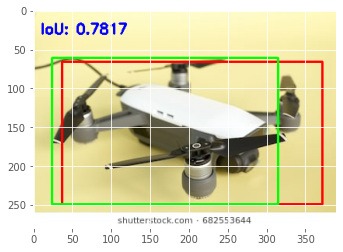

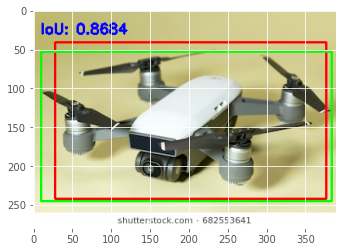

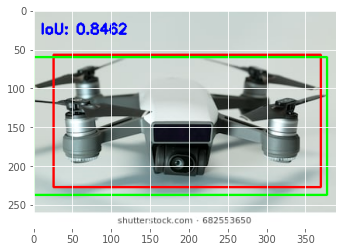

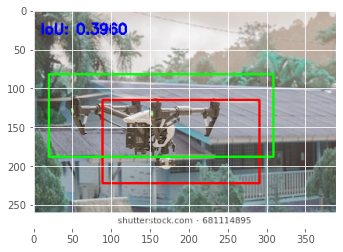

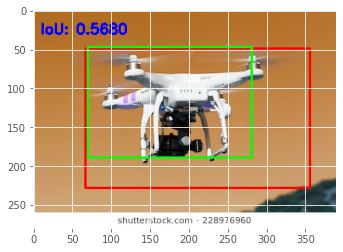

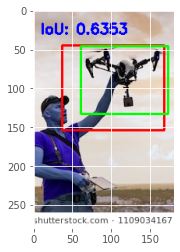

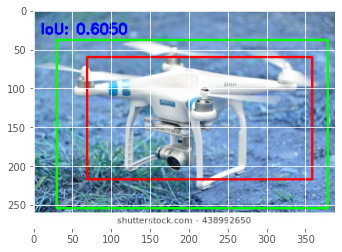

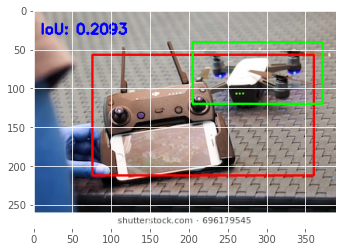

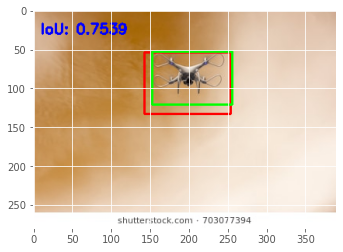

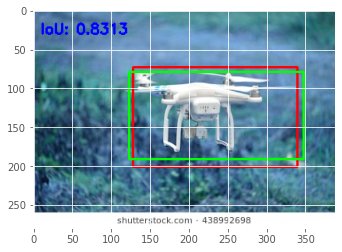

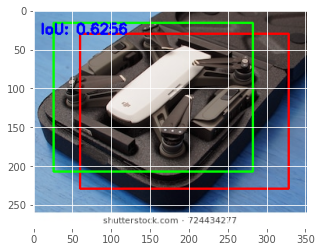

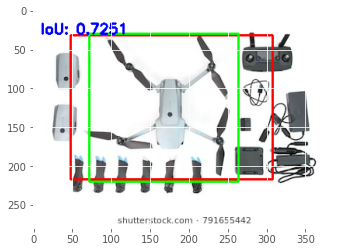

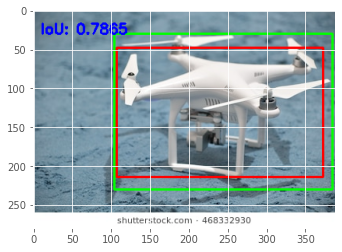

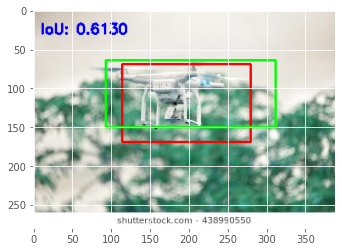

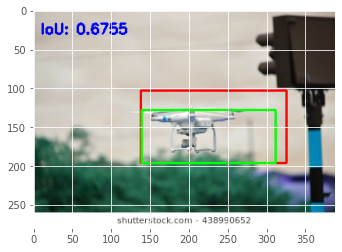

In [ ]:
# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)

# loop over the images that we'll be testing using our bounding box
# regression model

#plt.figure(figsize = (25,25))
i = 0
avg_iou = []
for imagePath, label in zip(imagePaths, labels):
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image) / 255.0
	image = np.expand_dims(image, axis=0)

	# make bounding box predictions on the input image
	preds = model.predict(image)[0]
	(startX_, startY_, endX_, endY_) = preds

	# load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
	image = cv2.imread(imagePath)
	(h, w) = image.shape[:2]

	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX_ = int(startX_ * w)
	startY_ = int(startY_ * h)
	endX_ = int(endX_ * w)
	endY_ = int(endY_ * h)

	# get the true label of the images
	row = open(label).read().split()
	(l, X, Y, W, H) = row
	X, Y, W, H = float(X), float(Y), float(W), float(H)

	startX = int(X)
	startY = int(Y)
	endX = int(X + W)
	endY = int(Y + H)

	# draw the predicted bounding box on the image
	cv2.rectangle(image, (startX_, startY_), (endX_, endY_),
	(255, 0, 0), 2)
	# draw the true bounding box on the image
	cv2.rectangle(image, (startX, startY), (endX, endY),
	(0, 255, 0), 2)

	# show the output image
	#plt.subplot(440 + 1 + i)
	iou = bb_intersection_over_union((startX_, startY_, endX_, endY_), (startX, startY, endX, endY))
	cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
	avg_iou.append(iou)
	plt.imshow(image)
	plt.show()
	# show the figure
	# i += 1
	# if i > 16:
	# 	break


In [ ]:
cal_iou = sum(avg_iou)/len(avg_iou)
print(cal_iou)

0.6452904930942249
